In [54]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense 

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

In [2]:
symbol = "BTCUSDT"
PERIOD = "1d"

# Origin data

In [3]:
pd_df = pd.read_csv(f"../../datastore/price/{symbol}_{PERIOD}.csv")
pd_df

,Kline open time,Open price,High price,Low price,Close price,Volume,Kline Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
0,1517356800000,10230.00,10425.85,9700.00,10285.10,18015.956805,1517443199999,1.816442e+08,201422,8782.584442,8.860927e+07
1,1517443200000,10285.10,10335.00,8750.99,9224.52,33564.764311,1517529599999,3.176363e+08,316020,15430.003849,1.461307e+08
2,1517529600000,9224.52,9250.00,8010.02,8873.03,49971.626975,1517615999999,4.342365e+08,453411,23113.503584,2.012927e+08
3,1517616000000,8873.03,9473.01,8229.00,9199.96,28725.000735,1517702399999,2.568347e+08,327519,14182.838146,1.270686e+08
4,1517702400000,9199.96,9368.00,7930.00,8184.81,32014.308449,1517788799999,2.749123e+08,356134,13805.295790,1.188846e+08
...,...,...,...,...,...,...,...,...,...,...,...
1795,1672444800000,16607.48,16644.09,16470.00,16542.40,114490.428640,1672531199999,1.897048e+09,3344374,57021.069190,9.448344e+08
1796,1672531200000,16541.77,16628.00,16499.01,16616.75,96925.413740,1672617599999,1.604794e+09,3218355,48548.781680,8.038417e+08
1797,1672617600000,16617.17,16799.23,16548.70,16672.87,121888.571910,1672703999999,2.034683e+09,4036118,60925.259480,1.017075e+09
1798,1672704000000,16672.78,16778.40,16605.28,16675.18,159541.537330,1672790399999,2.662766e+09,5097596,79595.762460,1.328471e+09


### Format open price and time

In [53]:
pd_df["Open price"] = pd_df["Open price"].apply(lambda price: float(price))
pd_df = pd_df.set_index("Kline open time").sort_index()
pd_df.index = pd.to_datetime(pd_df.index, unit='ms')
pd_df

,Open price,High price,Low price,Close price,Volume,Kline Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
Kline open time,,,,,,,,,,
2018-01-31,10230.00,10425.85,9700.00,10285.10,18015.956805,1517443199999,1.816442e+08,201422,8782.584442,8.860927e+07
2018-02-01,10285.10,10335.00,8750.99,9224.52,33564.764311,1517529599999,3.176363e+08,316020,15430.003849,1.461307e+08
2018-02-02,9224.52,9250.00,8010.02,8873.03,49971.626975,1517615999999,4.342365e+08,453411,23113.503584,2.012927e+08
2018-02-03,8873.03,9473.01,8229.00,9199.96,28725.000735,1517702399999,2.568347e+08,327519,14182.838146,1.270686e+08
2018-02-04,9199.96,9368.00,7930.00,8184.81,32014.308449,1517788799999,2.749123e+08,356134,13805.295790,1.188846e+08
...,...,...,...,...,...,...,...,...,...,...
2022-12-31,16607.48,16644.09,16470.00,16542.40,114490.428640,1672531199999,1.897048e+09,3344374,57021.069190,9.448344e+08
2023-01-01,16541.77,16628.00,16499.01,16616.75,96925.413740,1672617599999,1.604794e+09,3218355,48548.781680,8.038417e+08
2023-01-02,16617.17,16799.23,16548.70,16672.87,121888.571910,1672703999999,2.034683e+09,4036118,60925.259480,1.017075e+09


In [59]:
# plt.figure(figsize=(16,8),)
# plt.title("BTC/USDT open price")
# plt.plot(pd_df["Open price"])
# plt.ylabel("Price (BTC/USDT)")
# plt.xlabel("Date")
# plt.grid()
# plt.show()
fig = go.Figure(data=[go.Candlestick(x=pd_df.index,
                open=pd_df['Open price'],
                high=pd_df['High price'],
                low=pd_df['Low price'],
                close=pd_df['Close price'])])
# set new height and width
fig.update_layout(
    height=800,
    width=1000,
    title_text="BTC/USDT price",
    yaxis_title="Price (BTC/USDT)",
    xaxis_title="Date",
    xaxis_rangeslider_visible=True
)

fig.show()

In [6]:
dataset = pd_df.filter(["Open price"]).values

In [7]:
TRAIN_DATA_LENGTH = int(len(dataset) * 0.8)
dataset

array([[10230.  ],
       [10285.1 ],
       [ 9224.52],
       ...,
       [16617.17],
       [16672.78],
       [16675.65]])

In [18]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

In [19]:
scaled_data

array([[0.1091252 ],
       [0.10998193],
       [0.0934913 ],
       ...,
       [0.20843731],
       [0.20930197],
       [0.2093466 ]])

In [24]:
train_data = scaled_data[:TRAIN_DATA_LENGTH]

X_train = []
Y_train = []
for i in range(60,len(train_data)):
    X_train.append(train_data[i-60:i,:])
    Y_train.append(train_data[i,:])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])

In [72]:
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(200, return_sequences=False))
model.add(Dense(100))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [73]:
model.fit(X_train, Y_train, batch_size=1, epochs=2)

Epoch 1/2
1380/1380 [==============================] - 36s 25ms/step - loss: 0.0031
Epoch 2/2
1380/1380 [==============================] - 29s 21ms/step - loss: 0.0016


In [74]:
test_data = scaled_data[TRAIN_DATA_LENGTH-60:]

X_test = []
Y_test = []
for i in range(60,len(test_data)):
    X_test.append(test_data[i-60:i,:])
    Y_test.append(test_data[i,:])

X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [75]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

12/12 [==============================] - 1s 31ms/step


In [46]:
data = pd_df.filter(["Open price"])
train = data[:TRAIN_DATA_LENGTH]
valid = data[TRAIN_DATA_LENGTH:].reset_index()
valid["predict_price"] = predictions
valid = valid.set_index("Kline open time")
valid["predict_price"]= valid["predict_price"].apply(lambda price: float(price))

NameError: name 'predictions' is not defined

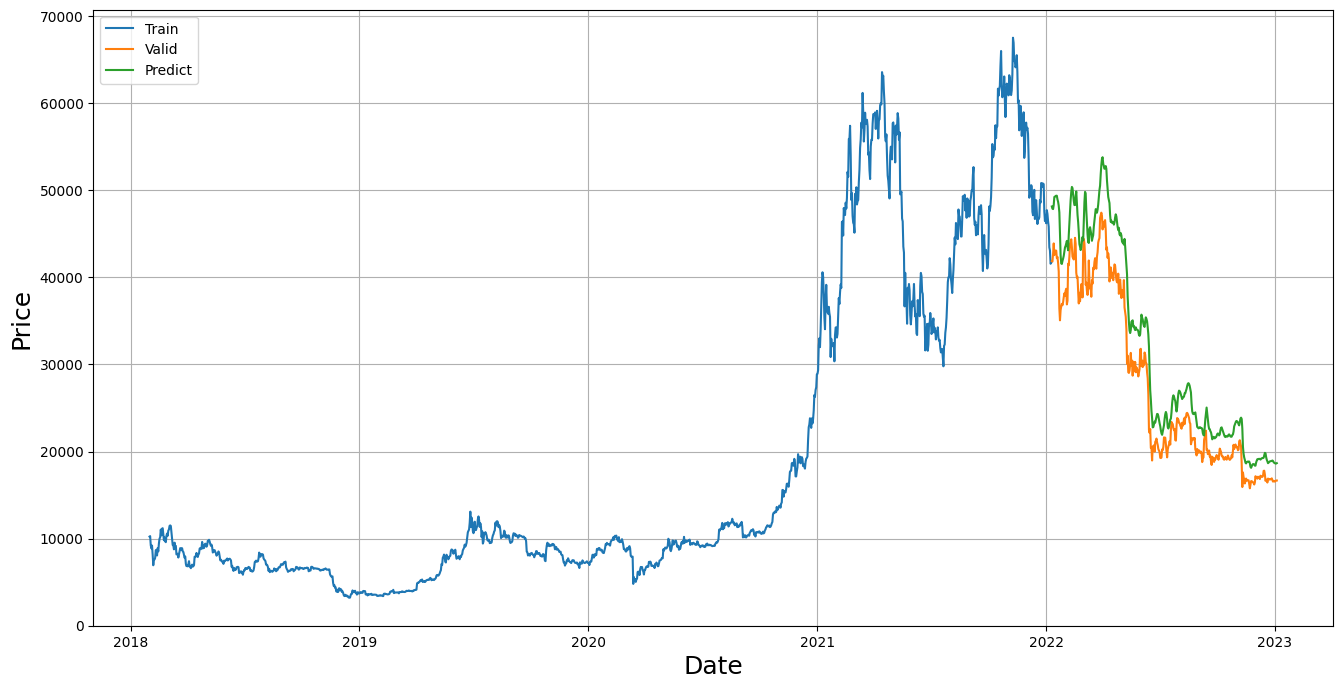

In [77]:
plt.figure(figsize=(16,8))
plt.xlabel("Date", fontsize= 18)
plt.ylabel("Price", fontsize= 18)
plt.plot(train["Open price"])
plt.plot(valid[["Open price","predict_price"]])
plt.legend(["Train","Valid", "Predict"],loc="upper left")
plt.grid()
plt.show()


In [78]:
X_test = scaled_data[-60:]
X_test = np.array(X_test)
X_test = X_test.reshape(1, 60, 1)
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

1/1 [==============================] - 0s 29ms/step


### Recent price

In [79]:
data[-10:]

,Open price
Kline open time,
2022-12-26,16832.11
2022-12-27,16919.39
2022-12-28,16706.06
2022-12-29,16547.32
2022-12-30,16633.47
2022-12-31,16607.48
2023-01-01,16541.77
2023-01-02,16617.17
2023-01-03,16672.78


### Tomorrow price

In [80]:
predictions[0,0]

18702.23

In [81]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SimpleExpSmoothing, Holt

In [82]:
# X = pd_df["Open price"].values

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data).reshape(-1)
train, test = scaled_data[:TRAIN_DATA_LENGTH], scaled_data[TRAIN_DATA_LENGTH:]
history = train.copy().tolist()

predictions = list()
for t in range(len(test)):
    model = SimpleExpSmoothing(history, initialization_method="estimated")
    # model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    pred_price = output[0]
    predictions.append(pred_price)
    actual_price = test[t]
    history.append(actual_price)

/var/folders/p7/08wxvf195r35gt2pw893ynsw0000gn/T/ipykernel_7537/3608748059.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



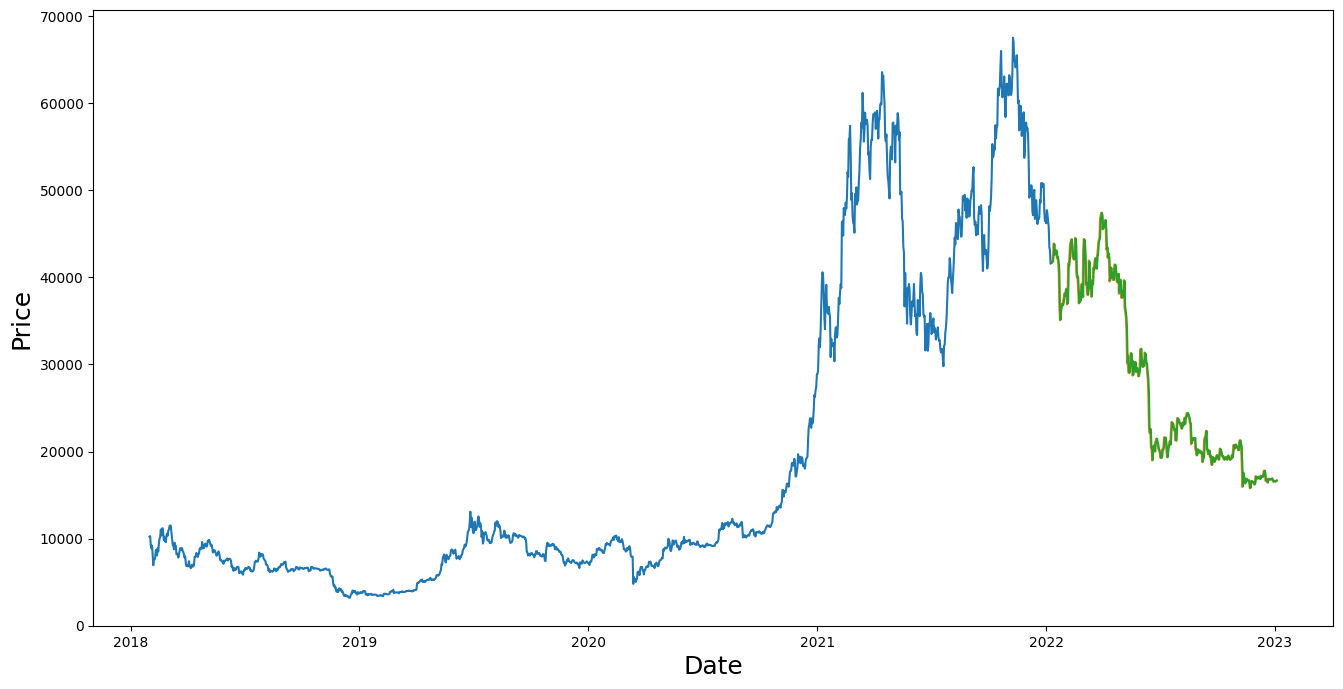

In [83]:
train_df, test_df = data[:TRAIN_DATA_LENGTH], data[TRAIN_DATA_LENGTH:]
test_df["Predict"] = scaler.inverse_transform(np.array(predictions).reshape(-1,1)).reshape(-1)

plt.figure(figsize=(16,8))
plt.xlabel("Date", fontsize= 18)
plt.ylabel("Price", fontsize= 18)
plt.plot(train_df["Open price"])
plt.plot(test_df[["Open price","Predict"]])
plt.show()

In [84]:
model = ARIMA(data["Open price"].values, order=(5,1,0))
model_fit = model.fit()
output = model_fit.forecast()
pred_price = output[0]

### Tomorrow price

In [85]:
pred_price

16674.775494990434

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from estimator import ArimaEstimator, LSTMEstimator, SarimaxEstimator, AutoRegEstimator, ExponentialSmoothingEstimator, HoltEstimator

# cross vadiation strategy
tscv = TimeSeriesSplit()

# mean squared error metric
metric = make_scorer(mean_squared_error)

# models
estimators = [
    ArimaEstimator(), 
    SarimaxEstimator(), 
    AutoRegEstimator(),
    ExponentialSmoothingEstimator(), 
    HoltEstimator(),
    LSTMEstimator(), 
]

scores_dict = {}

for estimator in estimators:
    scores = cross_val_score(estimator, X_train, Y_train, scoring=metric, cv=tscv, n_jobs=-1)
    print(estimator.__class__.__name__, scores.mean())
    scores_dict[estimator.__class__.__name__] = scores
    
scores_df = pd.DataFrame(scores_dict)
scores_df.index = scores_df.index.map(lambda x: f'fold_{x+1}')
scores_df.loc['mean'] = scores_df.mean()
scores_df.to_csv('../../datastore/scores.csv')

In [36]:
scores_df

,ArimaEstimator,SarimaxEstimator,AutoRegEstimator,ExponentialSmoothingEstimator,HoltEstimator,LSTMEstimator
fold_1,0.000026,0.000031,0.000021,0.000019,0.000021,0.000328
fold_2,0.000027,0.000051,0.000025,0.000025,0.000026,0.000477
fold_3,0.000036,0.000052,0.000035,0.000031,0.000034,0.000041
fold_4,0.000823,0.001072,0.000795,0.000762,0.000778,0.001853
fold_5,0.000786,0.001202,0.000777,0.000711,0.000750,0.005032
mean,0.000340,0.000481,0.000331,0.000310,0.000322,0.001546


In [ ]:
# find column with lowest mean score
best_estimator = scores_df.loc['mean'].idxmin()
best_estimator

'ExponentialSmoothingEstimator'

In [ ]:
%%capture
from estimator import ExponentialSmoothingEstimator as Estimator
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

tscv = TimeSeriesSplit()

metric = make_scorer(mean_squared_error, greater_is_better=False)

param_grid = {
    'trend': ["add", "mul", "additive", "multiplicative", None],
    'damped_trend': [True, False],
    'seasonal': ["add", "mul", "additive", "multiplicative", None],
    'seasonal_periods': [7, 30, 365],
}

estimator = Estimator()
estimator.get_params().keys()
grid_search = GridSearchCV(estimator, param_grid, scoring=metric, cv=tscv, n_jobs=-1, verbose=0)
grid_search.fit(X_train, Y_train)

In [42]:
grid_search.best_estimator_

ExponentialSmoothingEstimator(seasonal_periods=7)

In [47]:
from statsmodels.tsa.api import ExponentialSmoothing

data = pd_df.filter(["Open price"])

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data).reshape(-1)
train, test = scaled_data[:TRAIN_DATA_LENGTH], scaled_data[TRAIN_DATA_LENGTH:]
history = train.copy().tolist()

predictions = list()
for t in range(len(test)):
    model = ExponentialSmoothing(history, seasonal_periods=7)
    model_fit = model.fit()
    output = model_fit.forecast()
    pred_price = output[0]
    predictions.append(pred_price)
    actual_price = test[t]
    history.append(actual_price)

In [50]:

train_df, test_df = data[:TRAIN_DATA_LENGTH], data[TRAIN_DATA_LENGTH:]
test_df["Predict"] = scaler.inverse_transform(np.array(predictions).reshape(-1,1)).reshape(-1)


# concate train_df and test_df to get the full data set
full_df = pd.concat([train_df, test_df], axis=0)


fig = px.line(full_df, height=1000, width=1000)
fig.show()

/var/folders/p7/08wxvf195r35gt2pw893ynsw0000gn/T/ipykernel_5700/4056533527.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["Predict"] = scaler.inverse_transform(np.array(predictions).reshape(-1,1)).reshape(-1)


In [60]:
full_df

,Open price,Predict
Kline open time,,
2018-01-29,11879.95,NaN
2018-01-30,11250.11,NaN
2018-01-31,10230.00,NaN
2018-02-01,10285.10,NaN
2018-02-02,9224.52,NaN
...,...,...
2022-12-29,16547.32,16714.316775
2022-12-30,16633.47,16553.887678
2022-12-31,16607.48,16630.339896


In [51]:
model = ExponentialSmoothing(data["Open price"].values, seasonal_periods=7)
model_fit = model.fit()
output = model_fit.forecast()
pred_price = output[0]

In [52]:
pred_price

16675.44488341002